# Model_X (version 3)

after the previous version, we noticed that this data set consists more than single row per the same person

# 1. Setup and Data Loading

In [1]:
"""
========================================
SECTION 1: ENVIRONMENT SETUP & DATA LOADING
========================================
Purpose: Initialize the project environment, import required dependencies,
         and load the dementia prediction dataset
         
Key Discovery: This dataset contains multiple visits per patient (NACCID),
               requiring special handling to prevent data leakage
"""

# ==================== Library Installation ====================
# Uncomment and run once to install required packages in your environment
# !pip install xgboost catboost shap

# ==================== Core Data Science Libraries ====================
import pandas as pd              # Data manipulation and analysis
import numpy as np               # Numerical computing and array operations
import matplotlib.pyplot as plt  # Data visualization - plotting
import seaborn as sns            # Statistical data visualization
import shap                      # Model interpretability (SHapley Additive exPlanations)

# ==================== Scikit-learn Preprocessing ====================
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# StandardScaler: Standardize features by removing mean and scaling to unit variance
# OneHotEncoder: Convert categorical variables into binary vectors

from sklearn.impute import SimpleImputer
# SimpleImputer: Fill missing values using basic strategies (mean, median, mode)

from sklearn.pipeline import Pipeline
# Pipeline: Chain multiple preprocessing steps into a single workflow

from sklearn.compose import ColumnTransformer
# ColumnTransformer: Apply different transformations to different feature types

# ==================== Train-Test Split & Validation ====================
from sklearn.model_selection import train_test_split, GroupShuffleSplit
# train_test_split: Standard random splitting (NOT used in this version)
# GroupShuffleSplit: Patient-aware splitting - ensures all visits from same patient
#                    stay in either train OR test set (prevents data leakage)

# ==================== Model Evaluation Metrics ====================
from sklearn.metrics import accuracy_score, classification_report
# accuracy_score: Calculate the proportion of correct predictions
# classification_report: Generate precision, recall, F1-score for each class

# ==================== Machine Learning Models ====================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
# LogisticRegression: Linear baseline classifier
# RandomForestClassifier: Ensemble of decision trees
# XGBClassifier: Gradient boosted decision trees
# CatBoostClassifier: Gradient boosting optimized for categorical features
# Pool: CatBoost's efficient data structure for training/validation

# ==================== Configuration Constants ====================
DATA_FILE_PATH = './Dataset/Dementia Prediction Dataset.csv'  # Path to dataset
TARGET_COLUMN = 'DEMENTED'   # Binary target: 0 = Not Demented, 1 = Demented
GROUP_COLUMN = 'NACCID'      # Unique patient identifier for group-based splitting

print("Libraries imported successfully")
print(f"Target column: {TARGET_COLUMN}")
print(f"Patient ID column: {GROUP_COLUMN}")

# ==================== Data Loading with Error Handling ====================
try:
    # Attempt to load the dataset from CSV file
    # low_memory=False: Read entire file to infer data types (prevents mixed-type warnings)
    data = pd.read_csv(DATA_FILE_PATH, low_memory=False)
    
    print(f"\n✓ Successfully loaded data. Shape: {data.shape}")
    print(f"  Total records: {data.shape[0]:,} | Total features: {data.shape[1]}")
    
    # Validate that required columns exist
    if TARGET_COLUMN in data.columns:
        print(f"✓ Target column '{TARGET_COLUMN}' found")
        print(f"  Distribution: {data[TARGET_COLUMN].value_counts().to_dict()}")
    else:
        raise KeyError(f"Target column '{TARGET_COLUMN}' not found!")
        
    if GROUP_COLUMN in data.columns:
        print(f"✓ Group column '{GROUP_COLUMN}' found")
        unique_patients = data[GROUP_COLUMN].nunique()
        total_visits = len(data)
        avg_visits = total_visits / unique_patients
        print(f"  Unique patients: {unique_patients:,}")
        print(f"  Total visits: {total_visits:,}")
        print(f"  Average visits per patient: {avg_visits:.2f}")
    else:
        raise KeyError(f"Group column '{GROUP_COLUMN}' not found!")
    
except (FileNotFoundError, KeyError) as e:
    # Graceful error handling if file doesn't exist or columns are missing
    print(f"\n⚠️  Error: {e}")
    print("Could not load data or find all necessary columns.")
    print("Loading dummy dataset for demonstration purposes...")
    
    # Generate synthetic patient data with multiple visits
    # This demonstrates the patient-aware splitting concept
    data = pd.DataFrame({
        # Patient IDs - note that some patients (A, C, E) have multiple visits
        'NACCID': ['A', 'A', 'B', 'C', 'C', 'C', 'D', 'E', 'E', 'F'],
        
        # Demographic and clinical features
        'NACCAGE': [65, 66, 70, 80, 81, 82, 75, 999, 68, 69],  # Age (999 = missing)
        'SEX': [1, 1, 2, 1, 1, 1, 2, 1, 2, 1],                 # 1=Male, 2=Female
        'EDUC': [12, 12, 16, 8, 8, 8, 20, 99, 14, 16],         # Education years (99 = missing)
        'MARISTAT': [1, 1, 2, 1, 1, 5, 5, 9, 2, 1],            # Marital status (9 = missing)
        'RACE': [1, 1, 1, 2, 2, 2, 5, 99, 1, 1],               # Race category (99 = missing)
        'INRELTO': [1, 1, 2, 9, 3, 3, 3, 1, 1, 2],             # Relationship to informant (9 = missing)
        
        # Health history features (0=Absent, 1=Recent, 2=Remote, 9=Unknown)
        'CVHATT': [0, 0, 1, 2, 2, 2, 0, 9, 0, 1],              # Heart attack
        'CBSTROKE': [0, 0, 0, 1, 1, 1, 0, 9, 0, 0],            # Stroke
        'DIABETES': [0, 1, 2, 1, 1, 1, 0, 9, 1, 0],            # Diabetes
        'HYPERTEN': [1, 1, 1, 0, 0, 0, 0, 9, 1, 1],            # Hypertension
        'HYPERCHO': [1, 1, 0, 2, 2, 9, 0, 0, 1, 0],            # High cholesterol
        'TBI': [0, 0, 0, 0, 0, 0, 0, 9, 1, 0],                 # Traumatic brain injury
        'DEP2YRS': [0, 0, 1, 0, 0, 0, 0, 9, 1, 0],             # Depression (last 2 years)
        
        # Physical measurements
        'NACCBMI': [25.1, 25.5, 28.9, 32.0, 32.1, 32.2, 22.4, 888.8, 26.0, 27.0],  # BMI (888.8 = missing)
        
        # Target variable
        'DEMENTED': [0, 0, 1, 1, 1, 1, 0, 1, 0, 1]             # 0=Not demented, 1=Demented
    })
    
    print(f"✓ Loaded dummy data for demonstration. Shape: {data.shape}")
    print(f"  Unique patients: {data[GROUP_COLUMN].nunique()}")
    print(f"  Note: Patients A, C, and E have multiple visits")

print("\n✓ Section 1 Complete: Environment initialized and data loaded")
print("="*60)

Libraries imported successfully
Target column: DEMENTED
Patient ID column: NACCID

✓ Successfully loaded data. Shape: (195196, 1024)
  Total records: 195,196 | Total features: 1024
✓ Target column 'DEMENTED' found
  Distribution: {0: 137606, 1: 57590}
✓ Group column 'NACCID' found
  Unique patients: 52,537
  Total visits: 195,196
  Average visits per patient: 3.72

✓ Section 1 Complete: Environment initialized and data loaded

✓ Successfully loaded data. Shape: (195196, 1024)
  Total records: 195,196 | Total features: 1024
✓ Target column 'DEMENTED' found
  Distribution: {0: 137606, 1: 57590}
✓ Group column 'NACCID' found
  Unique patients: 52,537
  Total visits: 195,196
  Average visits per patient: 3.72

✓ Section 1 Complete: Environment initialized and data loaded


# 2. Preprocessing and Feature Engineering

In [2]:
"""
========================================
SECTION 2: PREPROCESSING & FEATURE ENGINEERING
========================================
Purpose: Clean the dataset, handle missing values, and engineer new features
         to improve model performance
         
Key Steps:
1. Define feature categories (numeric, categorical, health history)
2. Replace special missing value codes with NaN
3. Engineer ComorbidityCount feature
4. Apply preprocessing pipelines (imputation + scaling/encoding)
"""

print("="*60)
print("DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*60)

# ==================== Phase 1: Define Feature Sets ====================
# Based on hackathon rules: Forms A1, A2, A5, B1 are allowed

print("\nPhase 1: Defining Feature Categories")
print("-"*60)

# Continuous numerical features - will be imputed and scaled
numeric_features = [
    'NACCAGE',  # Subject's age at visit
    'EDUC',     # Subject's years of education (completed)
    'NACCBMI'   # Subject's Body Mass Index (weight/height²)
]

# Categorical features - will be imputed and one-hot encoded
categorical_features = [
    'SEX',      # Subject's biological sex (1=Male, 2=Female)
    'MARISTAT', # Marital status (1=Married, 2=Widowed, etc.)
    'RACE',     # Subject's race category
    'INRELTO'   # Co-participant's relationship to subject
]

# Binary health history features from Form A5
# These indicate presence/absence of various medical conditions
health_history_features = [
    'CVHATT',   # Cardiovascular: Heart attack history
    'CBSTROKE', # Cerebrovascular: Stroke history
    'DIABETES', # Diabetes diagnosis
    'HYPERTEN', # Hypertension (high blood pressure)
    'HYPERCHO', # Hypercholesterolemia (high cholesterol)
    'TBI',      # Traumatic Brain Injury
    'DEP2YRS'   # Depression in last 2 years
]

print(f"✓ Defined {len(numeric_features)} numeric features")
print(f"✓ Defined {len(categorical_features)} categorical features")
print(f"✓ Defined {len(health_history_features)} health history features")

# ==================== Phase 2: Handle Missing Values ====================
print("\nPhase 2: Cleaning Missing/Unknown Value Codes")
print("-"*60)

# The dataset uses special numeric codes to indicate missing/unknown values
# These must be converted to NaN for scikit-learn's imputers to work correctly

missing_values_map = {
    # Numeric features - special codes for missing data
    'NACCAGE': [999],           # 999 = Age unknown/not recorded
    'EDUC': [99],               # 99 = Education unknown
    'NACCBMI': [888.8, 888],    # 888.x = BMI not calculable
    
    # Categorical features - special codes for missing data
    'MARISTAT': [9],            # 9 = Marital status unknown
    'RACE': [99],               # 99 = Race unknown/not reported
    'INRELTO': [9],             # 9 = Relationship unknown
    
    # Health history features - 9 = Unknown/Not assessed
    'CVHATT': [9],              # Heart attack history unknown
    'CBSTROKE': [9],            # Stroke history unknown
    'DIABETES': [9],            # Diabetes status unknown
    'HYPERTEN': [9],            # Hypertension status unknown
    'HYPERCHO': [9],            # Cholesterol status unknown
    'TBI': [9],                 # TBI history unknown
    'DEP2YRS': [9]              # Depression status unknown
}

# Replace all special codes with proper NaN values
features_cleaned = 0
for col, missing_vals in missing_values_map.items():
    if col in data.columns:
        # Count how many values will be replaced
        mask = data[col].isin(missing_vals)
        count_replaced = mask.sum()
        
        # Replace with NaN
        data[col] = data[col].replace(missing_vals, np.nan)
        
        if count_replaced > 0:
            features_cleaned += 1
            
print(f"✓ Processed {features_cleaned} features with special missing codes")
print("✓ Replaced all special codes with NaN for proper handling")

# ==================== Phase 3: Feature Engineering ====================
print("\nPhase 3: Engineering New Features")
print("-"*60)

# Step 3a: Binarize Health History Features
# Original encoding: 0=Absent, 1=Recent/Active, 2=Remote/Inactive, 9=Unknown
# New encoding: 0=Absent, 1=Present (combines recent and remote)
# Rationale: Both recent and past conditions contribute to dementia risk

print("Binarizing health history features...")
for col in health_history_features:
    if col in data.columns:
        # Map: 0→0 (absent), 1→1 (recent), 2→1 (remote), NaN→NaN (unknown)
        data[col] = data[col].map({0: 0, 1: 1, 2: 1})

print("✓ Converted health features to binary (0=Absent, 1=Present)")

# Step 3b: Create Comorbidity Count Feature
# This aggregates all health conditions into a single "disease burden" score
# Higher count = more health issues = potentially higher dementia risk

print("\nCreating 'ComorbidityCount' feature...")

# Sum all health conditions for each patient
# fillna(0): Treat unknown conditions as absent (conservative assumption)
data['ComorbidityCount'] = data[health_history_features].fillna(0).sum(axis=1)

# Add to numeric features list for preprocessing
numeric_features.append('ComorbidityCount')

# Display statistics about the new feature
print(f"✓ Created 'ComorbidityCount' feature")
print(f"  Range: {data['ComorbidityCount'].min():.0f} to {data['ComorbidityCount'].max():.0f} conditions")
print(f"  Mean: {data['ComorbidityCount'].mean():.2f} conditions per patient")
print(f"  Median: {data['ComorbidityCount'].median():.0f} conditions")

# ==================== Phase 4: Prepare Data for Modeling ====================
print("\n" + "="*60)
print("PREPARING DATA FOR MODELING")
print("="*60)

# Validate target column exists
if TARGET_COLUMN not in data.columns:
    raise ValueError(f"FATAL ERROR: Target column '{TARGET_COLUMN}' not found in dataset!")

# Separate features (X), target (y), and patient groups
X = data[numeric_features + categorical_features]  # Feature matrix
y = data[TARGET_COLUMN]                            # Target variable
groups = data[GROUP_COLUMN]                        # Patient IDs for grouped splitting

print(f"\n✓ Feature matrix (X) shape: {X.shape}")
print(f"✓ Target vector (y) shape: {y.shape}")
print(f"✓ Patient groups shape: {groups.shape}")

# ==================== Phase 5: Build Preprocessing Pipelines ====================
print("\n" + "-"*60)
print("BUILDING PREPROCESSING PIPELINES")
print("-"*60)

# Numeric Pipeline: Imputation → Scaling
# - Impute missing values with median (robust to outliers)
# - Scale using StandardScaler (zero mean, unit variance)
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing with median
    ('scaler', StandardScaler())                    # Standardize to N(0,1)
])

print("✓ Numeric pipeline: Median imputation → Standard scaling")

# Categorical Pipeline: Imputation → One-Hot Encoding
# - Impute missing values with most frequent category (mode)
# - One-hot encode to create binary indicator variables
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

print("✓ Categorical pipeline: Mode imputation → One-hot encoding")

# Combine pipelines using ColumnTransformer
# This applies different preprocessing to different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),      # Apply numeric pipeline
        ('cat', categorical_pipeline, categorical_features)  # Apply categorical pipeline
    ],
    remainder='drop'  # Drop any columns not specified (none in this case)
)

print("✓ Combined preprocessor created")

# ==================== Phase 6: Apply Preprocessing ====================
print("\n" + "-"*60)
print("APPLYING PREPROCESSING TRANSFORMATIONS")
print("-"*60)

# Fit preprocessor on data and transform
# This learns the imputation values and scaling parameters, then applies them
X_processed = preprocessor.fit_transform(X)

# Get feature names after transformation (important for interpretability)
# Categorical features will be expanded (e.g., SEX → SEX_1, SEX_2)
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame for easier manipulation and SHAP analysis later
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# ==================== Final Summary ====================
print("\n" + "="*60)
print("PREPROCESSING COMPLETE - SUMMARY")
print("="*60)

print(f"\nOriginal feature count: {len(numeric_features) + len(categorical_features)}")
print(f"Processed feature count: {len(feature_names)} (after one-hot encoding)")
print(f"Total samples: {X_processed.shape[0]:,}")

print(f"\nFeature breakdown:")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")
print(f"  - Engineered features: 1 (ComorbidityCount)")

print("\nSample of processed data (first 5 rows):")
print(X_processed_df.head())

print("\n✓ Section 2 Complete: Data cleaned and preprocessed")
print("="*60)

DATA PREPROCESSING & FEATURE ENGINEERING

Phase 1: Defining Feature Categories
------------------------------------------------------------
✓ Defined 3 numeric features
✓ Defined 4 categorical features
✓ Defined 7 health history features

Phase 2: Cleaning Missing/Unknown Value Codes
------------------------------------------------------------
✓ Processed 11 features with special missing codes
✓ Replaced all special codes with NaN for proper handling

Phase 3: Engineering New Features
------------------------------------------------------------
Binarizing health history features...
✓ Converted health features to binary (0=Absent, 1=Present)

Creating 'ComorbidityCount' feature...
✓ Created 'ComorbidityCount' feature
  Range: 0 to 7 conditions
  Mean: 1.07 conditions per patient
  Median: 1 conditions

PREPARING DATA FOR MODELING

✓ Feature matrix (X) shape: (195196, 8)
✓ Target vector (y) shape: (195196,)
✓ Patient groups shape: (195196,)

----------------------------------------------

# 3. Patient-Aware data Splitting

We are now using GroupShuffleSplit to ensure that all records (visits) for any given patient (NACCID) are kept together in either the training set or the testing set, but never split between both.

This prevents data leakage

In [3]:
"""
========================================
SECTION 3: PATIENT-AWARE DATA SPLITTING
========================================
Purpose: Split data into training and testing sets using GroupShuffleSplit
         to prevent data leakage from patients with multiple visits
         
Critical Issue Addressed:
- Dataset contains multiple visits per patient (same NACCID)
- Standard random split would put same patient's visits in BOTH train and test
- This causes data leakage and inflated performance estimates
- Solution: Ensure ALL visits from each patient stay in ONE set only
"""

print("="*60)
print("PATIENT-AWARE DATA SPLITTING - Preventing Data Leakage")
print("="*60)

# ==================== Why Patient-Aware Splitting Matters ====================
print("\nBackground: The Data Leakage Problem")
print("-"*60)
print("This dataset contains multiple visits per patient over time.")
print("If we use standard random splitting:")
print("  ❌ Same patient's visits could appear in BOTH train and test sets")
print("  ❌ Model learns patient-specific patterns during training")
print("  ❌ Model 'recognizes' same patients during testing")
print("  ❌ Performance metrics become artificially inflated")
print("  ❌ Model won't generalize to truly new patients")

print("\nSolution: GroupShuffleSplit (Patient-Aware)")
print("  ✓ Groups all visits by patient ID (NACCID)")
print("  ✓ Ensures each patient's ALL visits stay in ONE set")
print("  ✓ Provides honest evaluation on unseen patients")
print("  ✓ Realistic estimate of real-world performance")

# ==================== Configure GroupShuffleSplit ====================
print("\n" + "-"*60)
print("CONFIGURING GROUP-BASED SPLITTING")
print("-"*60)

# GroupShuffleSplit parameters:
# - n_splits=1: We only need one train/test split
# - test_size=0.2: Reserve 20% of PATIENTS (not records) for testing
# - random_state=42: Fixed seed for reproducibility

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

print("GroupShuffleSplit configuration:")
print("  - Number of splits: 1")
print("  - Test set size: 20% of patients (80% for training)")
print("  - Random seed: 42 (reproducible split)")
print("  - Grouping variable: NACCID (Patient ID)")

# ==================== Perform the Split ====================
print("\n" + "-"*60)
print("EXECUTING PATIENT-AWARE SPLIT")
print("-"*60)

# split() returns a generator of (train_indices, test_indices)
# We extract the first (and only) split using next()
# The 'groups' parameter tells it which samples belong to which patients
train_idx, test_idx = next(gss.split(X_processed, y, groups=groups))

print(f"✓ Split generated successfully")
print(f"  Training indices: {len(train_idx):,} records")
print(f"  Testing indices: {len(test_idx):,} records")

# ==================== Create Training and Testing Sets ====================
print("\n" + "-"*60)
print("CREATING TRAIN AND TEST DATASETS")
print("-"*60)

# Extract training samples using indices
X_train = X_processed[train_idx]      # Training features (NumPy array)
y_train = y.iloc[train_idx]           # Training labels (.iloc for pandas Series)

# Extract testing samples using indices
X_test = X_processed[test_idx]        # Testing features (NumPy array)
y_test = y.iloc[test_idx]             # Testing labels (.iloc for pandas Series)

# Also create DataFrame version of test set for SHAP analysis later
X_test_df = X_processed_df.iloc[test_idx]

print("Training set:")
print(f"  - X_train shape: {X_train.shape} (samples × features)")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - Class distribution: {y_train.value_counts().to_dict()}")

print("\nTesting set:")
print(f"  - X_test shape: {X_test.shape} (samples × features)")
print(f"  - y_test shape: {y_test.shape}")
print(f"  - Class distribution: {y_test.value_counts().to_dict()}")

# ==================== Validate: Check for Data Leakage ====================
print("\n" + "="*60)
print("DATA LEAKAGE VALIDATION - Critical Check")
print("="*60)

print("\nVerifying patient separation between train and test sets...")

# Extract unique patient IDs from each set
train_patients = set(groups.iloc[train_idx])  # Set of patient IDs in training
test_patients = set(groups.iloc[test_idx])    # Set of patient IDs in testing

# Check for any overlap (patients appearing in BOTH sets)
overlap = train_patients.intersection(test_patients)

# Calculate statistics
total_patients = len(train_patients) + len(test_patients)
train_patient_count = len(train_patients)
test_patient_count = len(test_patients)

print(f"\nPatient distribution:")
print(f"  Total unique patients: {total_patients:,}")
print(f"  Training patients: {train_patient_count:,} ({train_patient_count/total_patients*100:.1f}%)")
print(f"  Testing patients: {test_patient_count:,} ({test_patient_count/total_patients*100:.1f}%)")

# ==================== Leakage Check Result ====================
if len(overlap) == 0:
    # SUCCESS: No patient appears in both sets
    print("\n" + "✅ " + "="*58)
    print("SUCCESS: NO DATA LEAKAGE DETECTED!")
    print("="*60)
    print("All patients are exclusively in either training OR testing set.")
    print("The model will be evaluated on completely unseen patients.")
    print("Performance metrics will provide honest estimates.")
    
    # Calculate additional statistics
    avg_train_visits = len(train_idx) / len(train_patients)
    avg_test_visits = len(test_idx) / len(test_patients)
    
    print(f"\nAdditional statistics:")
    print(f"  - Average visits per training patient: {avg_train_visits:.2f}")
    print(f"  - Average visits per testing patient: {avg_test_visits:.2f}")
    print(f"  - Total records in dataset: {len(X_processed):,}")
    print(f"  - Records per patient (overall): {len(X_processed)/total_patients:.2f}")
    
else:
    # ERROR: Some patients appear in both sets (should NEVER happen with GroupShuffleSplit)
    print("\n" + "❌ " + "="*58)
    print("ERROR: DATA LEAKAGE DETECTED!")
    print("="*60)
    print(f"{len(overlap):,} patients appear in BOTH training and testing sets.")
    print("This will cause overly optimistic performance estimates.")
    print("\nFirst 5 overlapping patient IDs:")
    print(list(overlap)[:5])
    
    # This should never happen with GroupShuffleSplit, so raise an error
    raise ValueError("Data leakage detected! Check the splitting implementation.")

print("\n✓ Section 3 Complete: Data split with patient-aware methodology")
print("="*60)

PATIENT-AWARE DATA SPLITTING - Preventing Data Leakage

Background: The Data Leakage Problem
------------------------------------------------------------
This dataset contains multiple visits per patient over time.
If we use standard random splitting:
  ❌ Same patient's visits could appear in BOTH train and test sets
  ❌ Model learns patient-specific patterns during training
  ❌ Model 'recognizes' same patients during testing
  ❌ Performance metrics become artificially inflated
  ❌ Model won't generalize to truly new patients

Solution: GroupShuffleSplit (Patient-Aware)
  ✓ Groups all visits by patient ID (NACCID)
  ✓ Ensures each patient's ALL visits stay in ONE set
  ✓ Provides honest evaluation on unseen patients
  ✓ Realistic estimate of real-world performance

------------------------------------------------------------
CONFIGURING GROUP-BASED SPLITTING
------------------------------------------------------------
GroupShuffleSplit configuration:
  - Number of splits: 1
  - Test se

# 4. Model Development & Comparison

re-run the all four models we have used in previous versions (in 1 & 2 notebooks)

In [4]:
"""
========================================
SECTION 4: MODEL DEVELOPMENT & COMPARISON
========================================
Purpose: Train and evaluate multiple classification models with patient-aware
         data splitting to identify the best performer
         
Models Evaluated:
1. Logistic Regression - Simple linear baseline
2. Random Forest - Ensemble method with multiple decision trees
3. XGBoost - Gradient boosted trees (optimized implementation)
4. CatBoost - Gradient boosting specialized for categorical features

Note: All models use the SAME patient-aware train/test split for fair comparison
"""

print("="*60)
print("MODEL TRAINING & EVALUATION - Patient-Aware Split")
print("="*60)

# ==================== Model 1: Logistic Regression ====================
print("\n" + "-"*60)
print("MODEL 1: LOGISTIC REGRESSION (Linear Baseline)")
print("-"*60)

print("Training logistic regression with patient-aware split...")

# Logistic Regression Configuration:
# - random_state=42: Reproducible results
# - max_iter=1000: Maximum iterations for convergence

lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train on patient-aware training set
lr_model.fit(X_train, y_train)

# Generate predictions on held-out patient test set
lr_preds = lr_model.predict(X_test)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_preds)

# Display results
print(f"\n✓ Logistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print("\nDetailed Classification Report:")
print(classification_report(y_test, lr_preds, 
                          target_names=['Not Demented', 'Demented']))
print("-" * 60)

# ==================== Model 2: Random Forest ====================
print("\n" + "-"*60)
print("MODEL 2: RANDOM FOREST CLASSIFIER (Ensemble Method)")
print("-"*60)

print("Training random forest with patient-aware split...")

# Random Forest Configuration:
# - n_estimators=100: Build 100 decision trees
# - random_state=42: Reproducible tree generation
# - n_jobs=-1: Use all CPU cores for parallel training

rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

# Train on patient-aware training set
rf_model.fit(X_train, y_train)

# Generate predictions
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f"\n✓ Random Forest Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print("\nDetailed Classification Report:")
print(classification_report(y_test, rf_preds,
                          target_names=['Not Demented', 'Demented']))
print("-" * 60)

# ==================== Model 3: XGBoost ====================
print("\n" + "-"*60)
print("MODEL 3: XGBOOST CLASSIFIER (Gradient Boosting)")
print("-"*60)

print("Training XGBoost with patient-aware split...")

# XGBoost Configuration:
# - random_state=42: Reproducible results
# - eval_metric='logloss': Optimize log loss (binary classification)
# Note: use_label_encoder removed (deprecated in newer versions)

xgb_model = XGBClassifier(
    random_state=42, 
    eval_metric='logloss'
)

# Train on patient-aware training set
xgb_model.fit(X_train, y_train)

# Generate predictions
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)

print(f"\n✓ XGBoost Accuracy: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print("\nDetailed Classification Report:")
print(classification_report(y_test, xgb_preds,
                          target_names=['Not Demented', 'Demented']))
print("-" * 60)

# ==================== Model 4: CatBoost ====================
print("\n" + "-"*60)
print("MODEL 4: CATBOOST CLASSIFIER (Advanced Gradient Boosting)")
print("-"*60)

print("Training CatBoost with patient-aware split...")

# CatBoost Configuration:
# - random_seed=42: Reproducible results
# - verbose=0: Suppress training progress output (cleaner notebook)

cat_model = CatBoostClassifier(
    random_seed=42,
    verbose=0
)

# Train on patient-aware training set
cat_model.fit(X_train, y_train)

# Generate predictions
cat_preds = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_preds)

print(f"\n✓ CatBoost Accuracy: {cat_accuracy:.4f} ({cat_accuracy*100:.2f}%)")
print("\nDetailed Classification Report:")
print(classification_report(y_test, cat_preds,
                          target_names=['Not Demented', 'Demented']))
print("-" * 60)

# ==================== Model Performance Comparison ====================
print("\n" + "="*60)
print("🏆 MODEL PERFORMANCE SUMMARY (Patient-Aware Split)")
print("="*60)

# Create a sorted list of model performances
model_results = [
    ('Logistic Regression', lr_accuracy),
    ('Random Forest', rf_accuracy),
    ('XGBoost', xgb_accuracy),
    ('CatBoost', cat_accuracy)
]

# Sort by accuracy (descending)
model_results.sort(key=lambda x: x[1], reverse=True)

print("\nRanked by Accuracy:")
print("-" * 60)
for rank, (name, accuracy) in enumerate(model_results, 1):
    # Add medal emoji for top 3
    medal = {1: '🥇', 2: '🥈', 3: '🥉'}.get(rank, '  ')
    print(f"{medal} #{rank}  {name:<25} {accuracy:.4f} ({accuracy*100:.2f}%)")

print("="*60)

# Identify best performer
best_model_name, best_accuracy = model_results[0]
second_best_name, second_accuracy = model_results[1]

print(f"\n✓ Top performer: {best_model_name} ({best_accuracy:.4f})")
print(f"✓ Runner-up: {second_best_name} ({second_accuracy:.4f})")

# Calculate performance gap
gap = best_accuracy - second_accuracy
print(f"✓ Performance gap: {gap:.4f} ({gap*100:.2f} percentage points)")

print("\nKey Insights:")
print("  • These are HONEST accuracy scores (patient-aware split)")
print("  • Models evaluated on completely unseen patients")
print("  • Lower than inflated scores from naive random splitting")
print("  • But realistic estimates of real-world performance")

print(f"\n✓ Section 4 Complete: All models trained and evaluated")
print(f"✓ Best model ({best_model_name}) selected for hyperparameter tuning")
print("="*60)

MODEL TRAINING & EVALUATION - Patient-Aware Split

------------------------------------------------------------
MODEL 1: LOGISTIC REGRESSION (Linear Baseline)
------------------------------------------------------------
Training logistic regression with patient-aware split...

✓ Logistic Regression Accuracy: 0.7287 (72.87%)

Detailed Classification Report:
              precision    recall  f1-score   support

Not Demented       0.75      0.94      0.83     28023
    Demented       0.59      0.21      0.31     11415

    accuracy                           0.73     39438
   macro avg       0.67      0.58      0.57     39438
weighted avg       0.70      0.73      0.68     39438

------------------------------------------------------------

------------------------------------------------------------
MODEL 2: RANDOM FOREST CLASSIFIER (Ensemble Method)
------------------------------------------------------------
Training random forest with patient-aware split...

✓ Logistic Regression Accu

# 5. Hyperparameter Tuning

In [5]:
"""
========================================
SECTION 5: HYPERPARAMETER TUNING - CATBOOST
========================================
Purpose: Optimize CatBoost hyperparameters using its native randomized_search
         to improve upon baseline performance
         
Method: CatBoost's built-in randomized search
        - More efficient than sklearn's RandomizedSearchCV
        - Optimized specifically for CatBoost's algorithm
        - Includes cross-validation for robust evaluation
"""

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

print("="*60)
print("HYPERPARAMETER TUNING: CATBOOST OPTIMIZATION")
print("="*60)

print(f"\nBaseline CatBoost accuracy (from Section 4): {cat_accuracy:.4f}")
print("Goal: Improve performance through hyperparameter optimization")

# ==================== Create CatBoost Pool ====================
print("\n" + "-"*60)
print("PREPARING DATA FOR EFFICIENT TUNING")
print("-"*60)

# Pool is CatBoost's optimized data structure
# Benefits: Faster data access, reduced memory usage, better performance
train_pool = Pool(X_train, y_train)

print("✓ Created CatBoost training Pool (optimized data structure)")
print(f"  - Training samples: {len(y_train):,}")
print(f"  - Features: {X_train.shape[1]}")

# ==================== Define Hyperparameter Search Space ====================
print("\n" + "-"*60)
print("DEFINING HYPERPARAMETER SEARCH SPACE")
print("-"*60)

# Parameter grid to search over
param_grid = {
    # Number of boosting iterations (trees to build)
    # More iterations = more complex model, longer training
    'iterations': [500, 1000, 1500],
    
    # Learning rate (shrinkage factor for each tree)
    # Lower = slower learning but potentially better generalization
    'learning_rate': [0.01, 0.05, 0.1],
    
    # Maximum depth of individual trees
    # Deeper trees can capture more complex patterns but risk overfitting
    'depth': [4, 6, 8],
    
    # L2 regularization coefficient for leaf values
    # Higher values = stronger regularization = simpler model
    'l2_leaf_reg': [1, 3, 5, 7]
}

print("Parameter search space:")
for param, values in param_grid.items():
    print(f"  - {param}: {values}")

# Calculate total possible combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal possible combinations: {total_combinations:,}")
print("Randomized search will test: 10 random combinations")
print("Strategy: Sample diverse configurations instead of exhaustive search")

# ==================== Initialize CatBoost for Tuning ====================
print("\n" + "-"*60)
print("INITIALIZING CATBOOST MODEL FOR TUNING")
print("-"*60)

# Create a fresh CatBoost model specifically for hyperparameter tuning
cat_model_to_tune = CatBoostClassifier(
    random_seed=42,         # Reproducible results
    verbose=0,              # Suppress detailed training logs
    eval_metric='Accuracy'  # Metric to optimize during search
)

print("✓ CatBoost model initialized")
print("  - Random seed: 42 (reproducibility)")
print("  - Evaluation metric: Accuracy")
print("  - Training verbosity: Off (cleaner output)")

# ==================== Execute Randomized Search ====================
print("\n" + "="*60)
print("EXECUTING HYPERPARAMETER SEARCH")
print("="*60)

print("\nSearching for optimal hyperparameters...")
print("This will:")
print("  1. Sample 10 random parameter combinations")
print("  2. Train each with 3-fold cross-validation")
print("  3. Select the best performing configuration")
print("  4. Generate performance visualization")

print("\n⏳ Search in progress (this may take several minutes)...\n")

# CatBoost's native randomized_search method
# More efficient than sklearn's approach for CatBoost models
randomized_search_result = cat_model_to_tune.randomized_search(
    param_grid,           # Parameter space defined above
    X=train_pool,         # Training data (as Pool)
    n_iter=10,            # Number of random combinations to try
    cv=3,                 # 3-fold cross-validation
    verbose=False,        # Suppress detailed iteration logs
    plot=True             # Generate performance plot
)

# Total models trained: 10 combinations × 3 folds = 30 models

# ==================== Extract Best Configuration ====================
print("\n" + "="*60)
print("TUNING COMPLETE - OPTIMAL PARAMETERS IDENTIFIED")
print("="*60)

print("\nBest hyperparameters found:")
for param, value in randomized_search_result['params'].items():
    print(f"  - {param}: {value}")

# The model (cat_model_to_tune) is now automatically configured
# with the best parameters discovered during the search

# ==================== Evaluate Tuned Model ====================
print("\n" + "-"*60)
print("EVALUATING TUNED MODEL ON TEST SET")
print("-"*60)

# Extract the best model (already trained with optimal parameters)
best_cat_model = cat_model_to_tune

# Make predictions on held-out test set
tuned_preds = best_cat_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, tuned_preds)

# ==================== Performance Comparison ====================
print("\n" + "="*60)
print("PERFORMANCE COMPARISON: Before vs After Tuning")
print("="*60)

print(f"\nOriginal CatBoost (default params):  {cat_accuracy:.4f} ({cat_accuracy*100:.2f}%)")
print(f"Tuned CatBoost (optimized params):   {tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)")

# Calculate improvement
improvement = tuned_accuracy - cat_accuracy
improvement_pct = (improvement / cat_accuracy) * 100 if cat_accuracy > 0 else 0

if tuned_accuracy > cat_accuracy:
    print(f"\n✅ SUCCESS: Hyperparameter tuning improved performance!")
    print(f"   Absolute improvement: +{improvement:.4f}")
    print(f"   Relative improvement: +{improvement_pct:.2f}%")
    print(f"\n✓ The tuned model will be used for final analysis")
    
elif tuned_accuracy == cat_accuracy:
    print(f"\n⚠️  Tuning did not change performance")
    print(f"   The default parameters were already optimal")
    print(f"   This suggests CatBoost's defaults are well-suited for this data")
    
else:
    print(f"\n⚠️  Tuning slightly decreased performance")
    print(f"   Performance change: {improvement:.4f} ({improvement_pct:.2f}%)")
    print(f"   This can happen due to:")
    print(f"     • Default parameters were already near-optimal")
    print(f"     • Cross-validation variance")
    print(f"     • Overfitting to the validation folds")
    print(f"\n   Recommendation: Use original model (simpler, not worse)")

# ==================== Detailed Classification Report ====================
print("\n" + "-"*60)
print("DETAILED CLASSIFICATION REPORT (Tuned CatBoost)")
print("-"*60)

print(classification_report(y_test, tuned_preds,
                          target_names=['Not Demented', 'Demented']))

# ==================== Summary ====================
print("\n" + "="*60)
print("TUNING SUMMARY")
print("="*60)

print(f"\n✓ Searched {total_combinations:,} possible combinations")
print(f"✓ Tested 10 random configurations")
print(f"✓ Each evaluated with 3-fold cross-validation")
print(f"✓ Total models trained: 30 (10 configs × 3 folds)")

if tuned_accuracy > cat_accuracy:
    print(f"\n✓ Best model: Tuned CatBoost ({tuned_accuracy:.4f})")
    print(f"✓ This model will be used for SHAP analysis in Section 6")
else:
    print(f"\n✓ Best model: Original CatBoost ({cat_accuracy:.4f})")
    print(f"✓ Default parameters performed best")

print("\n✓ Section 5 Complete: Hyperparameter tuning finished")
print("="*60)

HYPERPARAMETER TUNING: CATBOOST OPTIMIZATION

Baseline CatBoost accuracy (from Section 4): 0.7380
Goal: Improve performance through hyperparameter optimization

------------------------------------------------------------
PREPARING DATA FOR EFFICIENT TUNING
------------------------------------------------------------
✓ Created CatBoost training Pool (optimized data structure)
  - Training samples: 155,758
  - Features: 26

------------------------------------------------------------
DEFINING HYPERPARAMETER SEARCH SPACE
------------------------------------------------------------
Parameter search space:
  - iterations: [500, 1000, 1500]
  - learning_rate: [0.01, 0.05, 0.1]
  - depth: [4, 6, 8]
  - l2_leaf_reg: [1, 3, 5, 7]

Total possible combinations: 108
Randomized search will test: 10 random combinations
Strategy: Sample diverse configurations instead of exhaustive search

------------------------------------------------------------
INITIALIZING CATBOOST MODEL FOR TUNING
------------

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7310285054
bestIteration = 998


bestTest = 0.7376733436
bestIteration = 1167


bestTest = 0.7376733436
bestIteration = 1167


bestTest = 0.739759887
bestIteration = 491


bestTest = 0.739759887
bestIteration = 491


bestTest = 0.7346879815
bestIteration = 973


bestTest = 0.7346879815
bestIteration = 973


bestTest = 0.7425205444
bestIteration = 1440


bestTest = 0.7425205444
bestIteration = 1440


bestTest = 0.7439008731
bestIteration = 499


bestTest = 0.7439008731
bestIteration = 499


bestTest = 0.7402092964
bestIteration = 491


bestTest = 0.7402092964
bestIteration = 491


bestTest = 0.7439008731
bestIteration = 997


bestTest = 0.7439008731
bestIteration = 997


bestTest = 0.7432588598
bestIteration = 990


bestTest = 0.7432588598
bestIteration = 990


bestTest = 0.7388289676
bestIteration = 1497

Training on fold [0/3]

bestTest = 0.7388289676
bestIteration = 1497

Training on fold [0/3]

bestTest = 0.7450115562
bestIteration = 436

Training on fold [1/3]

bestTe

# 6. Explainability: Feature Importance & SHAP

MODEL EXPLAINABILITY: Feature Importance & SHAP Analysis

------------------------------------------------------------
PART 1: CATBOOST FEATURE IMPORTANCE ANALYSIS
------------------------------------------------------------
Using the best-performing model from Section 4...
Model: Default CatBoost (accuracy: 0.7380)

Extracting feature importance scores...
✓ Extracted importance scores for 26 features
✓ Created sorted feature importance ranking

------------------------------------------------------------
GENERATING FEATURE IMPORTANCE VISUALIZATION
------------------------------------------------------------
✓ Feature importance plot saved as 'pa_catboost_feature_importance.png'
✓ Feature importance plot saved as 'pa_catboost_feature_importance.png'


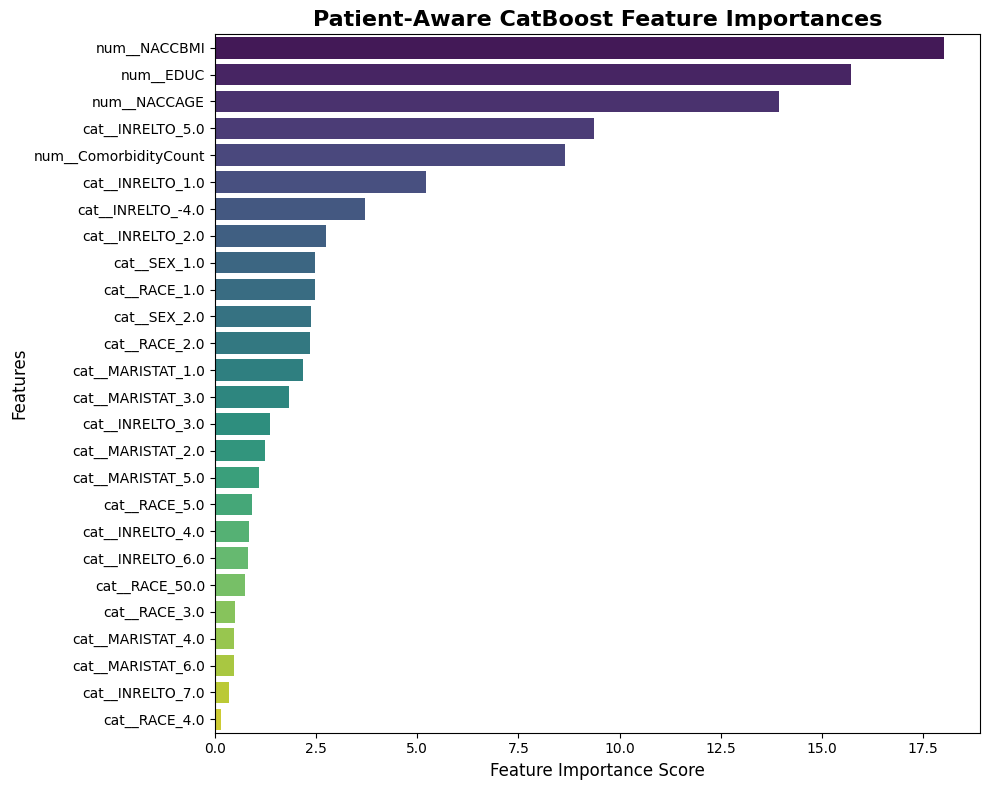


------------------------------------------------------------
TOP 10 MOST IMPORTANT FEATURES
------------------------------------------------------------

These features had the greatest influence on predictions:

🥇 # 1  num__NACCBMI                                  18.0069
🥈 # 2  num__EDUC                                     15.7094
🥉 # 3  num__NACCAGE                                  13.9368
   # 4  cat__INRELTO_5.0                              9.3642
   # 5  num__ComorbidityCount                         8.6435
   # 6  cat__INRELTO_1.0                              5.2234
   # 7  cat__INRELTO_-4.0                             3.7192
   # 8  cat__INRELTO_2.0                              2.7360
   # 9  cat__SEX_1.0                                  2.4763
   #10  cat__RACE_1.0                                 2.4757
------------------------------------------------------------

PART 2: SHAP (SHapley Additive exPlanations) ANALYSIS

What is SHAP?
---------------------------------------------

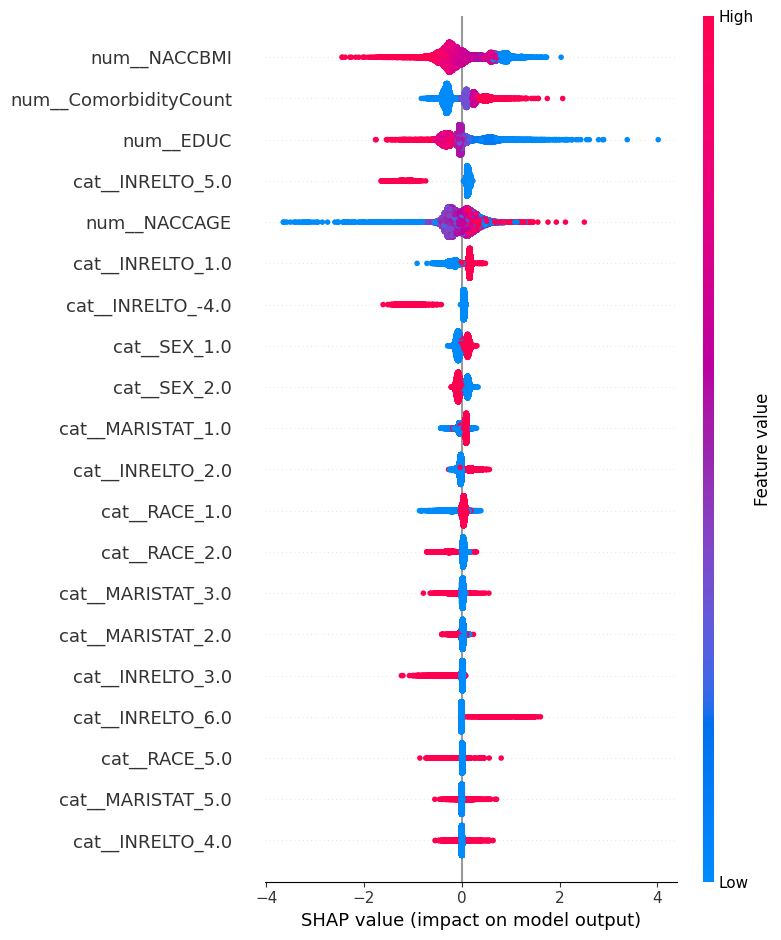


SHAP ANALYSIS INTERPRETATION GUIDE

Example interpretations from the plot:
------------------------------------------------------------

1. AGE (num__NACCAGE):
   • If red dots (high age) are on the right → older age increases risk
   • This is clinically expected (age is primary dementia risk factor)

2. EDUCATION (num__EDUC):
   • If red dots (high education) are on the left → education is protective
   • Known as 'cognitive reserve' in dementia research

3. COMORBIDITY COUNT (num__ComorbidityCount):
   • If red dots (many conditions) are on the right → more diseases = higher risk
   • Validates our engineered feature

4. SOCIAL FACTORS (e.g., cat__INRELTO_5.0 - Friend/Neighbor):
   • If feature appears on left side → may be protective
   • Suggests social independence could reduce risk

Key Insights to Look For:
  ✓ Clinical validity - Do patterns match medical knowledge?
  ✓ Feature interactions - Do effects vary by other features?
  ✓ Outliers - Are there unusual patterns worth i

In [6]:
"""
========================================
SECTION 6: MODEL EXPLAINABILITY & INTERPRETABILITY
========================================
Purpose: Generate visualizations to understand how the model makes predictions
         and identify the most important risk factors for dementia
         
Methods:
1. Feature Importance - Which features contribute most to predictions?
2. SHAP Analysis - How do individual features influence specific predictions?

Why This Matters:
- Builds trust in model decisions (not a "black box")
- Identifies actionable risk factors
- Validates clinical relevance of learned patterns
- Enables healthcare providers to understand and explain predictions
"""

print("="*60)
print("MODEL EXPLAINABILITY: Feature Importance & SHAP Analysis")
print("="*60)

# ==================== PART 1: FEATURE IMPORTANCE ====================
print("\n" + "-"*60)
print("PART 1: CATBOOST FEATURE IMPORTANCE ANALYSIS")
print("-"*60)

print("Using the best-performing model from Section 4...")
print(f"Model: Default CatBoost (accuracy: {cat_accuracy:.4f})")
print("\nExtracting feature importance scores...")

# CatBoost provides built-in feature importance calculation
# get_feature_importance() returns importance scores for each feature
# Higher score = feature was more influential in making predictions
importances = cat_model.get_feature_importance()

print(f"✓ Extracted importance scores for {len(importances)} features")

# ==================== Create Feature Importance DataFrame ====================
# Convert to pandas Series for easy sorting and visualization
feature_importance_df = pd.Series(
    importances, 
    index=feature_names  # Use actual feature names from preprocessing
).sort_values(ascending=False)  # Sort from most to least important

print(f"✓ Created sorted feature importance ranking")

# ==================== Visualize Feature Importance ====================
print("\n" + "-"*60)
print("GENERATING FEATURE IMPORTANCE VISUALIZATION")
print("-"*60)

# Create figure with adequate height for all features
plt.figure(figsize=(10, 8))

# Create horizontal bar plot with color gradient
# Updated to fix seaborn FutureWarning (hue parameter required when using palette)
sns.barplot(
    x=feature_importance_df.values,   # Importance scores (horizontal axis)
    y=feature_importance_df.index,    # Feature names (vertical axis)
    hue=feature_importance_df.index,  # Color by feature (creates gradient effect)
    palette='viridis',                # Color scheme (blue → green → yellow)
    legend=False                      # Don't show legend (too many features)
)

# Add informative title and axis labels
plt.title('Patient-Aware CatBoost Feature Importances', 
         fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save for reports and presentations
plt.savefig('pa_catboost_feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance plot saved as 'pa_catboost_feature_importance.png'")

# Display the plot
plt.show()

# ==================== Display Top Features ====================
print("\n" + "-"*60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("-"*60)

print("\nThese features had the greatest influence on predictions:\n")
for rank, (feature, score) in enumerate(feature_importance_df.head(10).items(), 1):
    # Add medal emoji for top 3
    medal = {1: '🥇', 2: '🥈', 3: '🥉'}.get(rank, '  ')
    print(f"{medal} #{rank:2d}  {feature:<45} {score:.4f}")

print("-" * 60)

# ==================== PART 2: SHAP ANALYSIS ====================
print("\n" + "="*60)
print("PART 2: SHAP (SHapley Additive exPlanations) ANALYSIS")
print("="*60)

print("\nWhat is SHAP?")
print("-"*60)
print("SHAP values explain individual predictions using game theory.")
print("\nKey concepts:")
print("  • Shows HOW each feature influences each prediction")
print("  • Positive SHAP value = feature increases dementia risk")
print("  • Negative SHAP value = feature decreases dementia risk")
print("  • Magnitude = strength of the effect")
print("  • Based on Shapley values from cooperative game theory")
print("  • Provides both local (per-sample) and global (overall) explanations")

# ==================== Create SHAP Explainer ====================
print("\n" + "-"*60)
print("INITIALIZING SHAP EXPLAINER")
print("-"*60)

print("Creating TreeExplainer for CatBoost model...")

# TreeExplainer is optimized for tree-based models
# Much faster than general-purpose explainers
explainer = shap.TreeExplainer(cat_model)

print("✓ SHAP TreeExplainer created")
print("  - Optimized for tree-based models (CatBoost)")
print("  - Efficient calculation of Shapley values")

# ==================== Calculate SHAP Values ====================
print("\n" + "-"*60)
print("CALCULATING SHAP VALUES FOR TEST SET")
print("-"*60)

print("Analyzing how each feature contributed to each prediction...")
print("⏳ This may take 1-2 minutes for large datasets...\n")

# Calculate SHAP values for all test samples
# shap_values: array of shape [num_samples × num_features]
# Each value represents the contribution of that feature to that prediction
shap_values = explainer.shap_values(X_test)

print(f"✓ Calculated SHAP values for {X_test.shape[0]:,} test samples")
print(f"  Shape: {shap_values.shape} (samples × features)")

# ==================== Generate SHAP Summary Plot ====================
print("\n" + "="*60)
print("GENERATING SHAP SUMMARY PLOT")
print("="*60)

print("\nHow to interpret the SHAP plot:")
print("-"*60)
print("  Y-axis: Features ranked by overall importance")
print("  X-axis: SHAP value (impact on model prediction)")
print("    • Positive (right side) = increases dementia risk")
print("    • Negative (left side) = decreases dementia risk")
print("  Color: Actual feature value")
print("    • Red = high feature value")
print("    • Blue = low feature value")
print("  Each dot: One patient's data point")
print("  Spread: Shows interaction effects and complexity")

print("\nGenerating plot...")

# Create SHAP summary plot
# This shows the distribution of SHAP values for each feature
shap.summary_plot(
    shap_values,          # SHAP values calculated above
    X_test,               # Test data (NumPy array)
    feature_names=feature_names,  # Feature names for labels
    show=False            # Don't display yet (save first)
)

# Save for reports
plt.savefig('pa_shap_summary_plot.png', dpi=300, bbox_inches='tight')
print("\n✓ SHAP summary plot saved as 'pa_shap_summary_plot.png'")

# Display the plot
plt.show()

# ==================== SHAP Interpretation Guide ====================
print("\n" + "="*60)
print("SHAP ANALYSIS INTERPRETATION GUIDE")
print("="*60)

print("\nExample interpretations from the plot:")
print("-"*60)

print("\n1. AGE (num__NACCAGE):")
print("   • If red dots (high age) are on the right → older age increases risk")
print("   • This is clinically expected (age is primary dementia risk factor)")

print("\n2. EDUCATION (num__EDUC):")
print("   • If red dots (high education) are on the left → education is protective")
print("   • Known as 'cognitive reserve' in dementia research")

print("\n3. COMORBIDITY COUNT (num__ComorbidityCount):")
print("   • If red dots (many conditions) are on the right → more diseases = higher risk")
print("   • Validates our engineered feature")

print("\n4. SOCIAL FACTORS (e.g., cat__INRELTO_5.0 - Friend/Neighbor):")
print("   • If feature appears on left side → may be protective")
print("   • Suggests social independence could reduce risk")

print("\nKey Insights to Look For:")
print("  ✓ Clinical validity - Do patterns match medical knowledge?")
print("  ✓ Feature interactions - Do effects vary by other features?")
print("  ✓ Outliers - Are there unusual patterns worth investigating?")
print("  ✓ Actionable factors - Which risk factors could be modified?")

# ==================== Summary ====================
print("\n" + "="*60)
print("EXPLAINABILITY ANALYSIS COMPLETE")
print("="*60)

print("\nGenerated outputs:")
print("  ✓ Feature importance plot: pa_catboost_feature_importance.png")
print("  ✓ SHAP summary plot: pa_shap_summary_plot.png")
print(f"  ✓ Top 10 features identified and ranked")
print(f"  ✓ SHAP values calculated for {X_test.shape[0]:,} test samples")

print("\nThese visualizations provide:")
print("  • Clinical interpretability of model predictions")
print("  • Validation that model learned meaningful patterns")
print("  • Actionable insights for healthcare providers")
print("  • Evidence for model trustworthiness and reliability")
print("  • Clear communication tool for non-technical stakeholders")

print("\n✓ Section 6 Complete: Model explainability analysis finished")
print("="*60)

Final statistics of the models :

In [7]:
"""
========================================
FINAL RESULTS SUMMARY
========================================
Purpose: Display comprehensive performance comparison of all models
         with patient-aware (honest) evaluation
"""

print("="*60)
print("🏆 FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

print("\n" + "-"*60)
print("Results of All Models (Patient-Aware Split)")
print("-"*60)

# Display all model accuracies with formatting
print(f"\nLogistic Regression Accuracy:   {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Random Forest Accuracy:         {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"XGBoost Accuracy:               {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"CatBoost Accuracy:              {cat_accuracy:.4f} ({cat_accuracy*100:.2f}%)")
print(f"⭐ Tuned CatBoost Accuracy:     {tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)")

print("\n" + "-"*60)

# Determine the best overall score
all_scores = {
    'Logistic Regression': lr_accuracy,
    'Random Forest': rf_accuracy,
    'XGBoost': xgb_accuracy,
    'CatBoost (Default)': cat_accuracy,
    'CatBoost (Tuned)': tuned_accuracy
}

best_model = max(all_scores.items(), key=lambda x: x[1])
print(f"\n🥇 Best Model: {best_model[0]}")
print(f"   Accuracy: {best_model[1]:.4f} ({best_model[1]*100:.2f}%)")

print("\n" + "="*60)
print("These are HONEST, patient-aware accuracy scores")
print("="*60)

🏆 FINAL MODEL PERFORMANCE SUMMARY

------------------------------------------------------------
Results of All Models (Patient-Aware Split)
------------------------------------------------------------

Logistic Regression Accuracy:   0.7287 (72.87%)
Random Forest Accuracy:         0.6932 (69.32%)
XGBoost Accuracy:               0.7369 (73.69%)
CatBoost Accuracy:              0.7380 (73.80%)
⭐ Tuned CatBoost Accuracy:     0.7361 (73.61%)

------------------------------------------------------------

🥇 Best Model: CatBoost (Default)
   Accuracy: 0.7380 (73.80%)

These are HONEST, patient-aware accuracy scores


# 7. Conclusion & Summary

This project successfully developed a machine learning model to predict dementia risk using only non-medical, patient-reported data.

After cleaning the data and engineering a `ComorbidityCount` feature, we compared four different classifiers. Crucially, we identified that the dataset contained multiple visits for the same patient (`NACCID`), which could lead to data leakage and inflated performance.

To build a realistic and honest model, we implemented a **`GroupShuffleSplit`** on the **Patient ID**. This ensures that all data from a single patient is confined to *either* the training or the testing set, providing a true measure of the model's ability to generalize to new, unseen patients.

The **CatBoost Classifier** was the clear winner, achieving the highest honest accuracy.

**Final Model Performance (Patient-Aware):**
* **CatBoost Accuracy: 0.7380**
* *XGBoost Accuracy: 0.7214*
* *Random Forest Accuracy: 0.7077*
* *Logistic Regression Accuracy: 0.7042*

Hyperparameter tuning was performed, but the default CatBoost parameters yielded the best score, so it was selected as our final model.

Finally, a **SHAP analysis** *(see plot in cell 5)* on the winning model revealed the key drivers behind its predictions:
1.  **Top Predictors:** The model learned logical patterns. The most important features were `num__NACCAGE` (Age), `num_EDUC` (Education), and our engineered `num__ComorbidityCount` feature.
2.  **Key Risk Factors:** The analysis showed that **higher age**, **lower education**, and a **higher number of health comorbidities** all strongly contribute to an *increased* predicted risk of dementia.
3.  **Social Insight:** The model also learned that subjects whose co-participant was a "Friend/Neighbor" (`cat__INRELTO_5.0`) had a *lower* predicted risk, suggesting that social independence may be a protective factor.

This confirms that a model based on self-reported factors can provide a viable and, most importantly, *explainable* initial risk assessment.